In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms

import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import random
#from helper import set_seed

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable
print(f"Using device: {device}")

Using device: cuda


In [3]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay,max_epochs):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            #self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos
    

    def inference_epoch(self, inference_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(inference_loader, desc="Inferencing", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(inference_loader)
        avg_top1_acc = total_top1_acc / len(inference_loader)
        avg_top5_acc = total_top5_acc / len(inference_loader)
        avg_mean_pos = total_mean_pos / len(inference_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [4]:
# Define file paths
model_path = r'C:\Users\k54739\saved_model\simclr_strongcrop_245.pth'

# below error suggests u need to load state rather than full

simclr_model = torch.load(model_path)
simclr_model.to(device)
simclr_model.eval()

In [5]:
# Reinitialize the model
simclr_model = SimCLR(hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4,max_epochs=245)
simclr_model.load_state_dict(torch.load(model_path))
simclr_model.to(device)
simclr_model.eval()
# Load the metrics
#loaded_metrics = torch.load(metrics_path)


C:\Users\k54739\AppData\Local\Temp\ipykernel_13336\2711482870.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simclr_model.load_state_dict(torch.load(model_path))


SimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

Inference before projection head

# Logistic

In [6]:
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [7]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    
    classes = ['sort_ds_ohne_cond10_ex', 'sort_ex_85']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\final_eval"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [8]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0])


In [9]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in train_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in train_loader_labeled: {total_images}")


Total number of images in train_loader_labeled: 239


In [10]:
# Initialize a counter
total_images = 0

# Iterate through the DataLoader
for anchor, label in test_loader_labeled:
    total_images += anchor.size(0)  # Increment by the batch size (number of images in the current batch)

# Print the total number of images
print(f"Total number of images in test_loader_labeled: {total_images}")


Total number of images in test_loader_labeled: 60


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [13]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

  7%|▋         | 1/15 [00:00<00:11,  1.23it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 13%|█▎        | 2/15 [00:01<00:09,  1.39it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 20%|██        | 3/15 [00:02<00:08,  1.43it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 27%|██▋       | 4/15 [00:02<00:07,  1.47it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 33%|███▎      | 5/15 [00:03<00:06,  1.47it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 40%|████      | 6/15 [00:04<00:06,  1.48it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 47%|████▋     | 7/15 [00:04<00:05,  1.48it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 53%|█████▎    | 8/15 [00:05<00:04,  1.43it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 60%|██████    | 9/15 [00:06<00:04,  1.49it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 67%|██████▋   | 10/15 [00:06<00:03,  1.52it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 73%|███████▎  | 11/15 [00:07<00:02,  1.52it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 80%|████████  | 12/15 [00:08<00:01,  1.55it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 87%|████████▋ | 13/15 [00:08<00:01,  1.53it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 93%|█████████▎| 14/15 [00:09<00:00,  1.53it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


Batch features shape: torch.Size([15, 512])
Batch labels shape: torch.Size([15])
Features shape after concatenation: torch.Size([239, 512])
Labels shape after concatenation: torch.Size([239])


 25%|██▌       | 1/4 [00:00<00:02,  1.46it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 2/4 [00:01<00:01,  1.48it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 3/4 [00:02<00:00,  1.46it/s]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

Batch features shape: torch.Size([12, 512])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([60, 512])
Labels shape after concatenation: torch.Size([60])


In [14]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [15]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [16]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [17]:
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                             drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Track best metrics
    best_train_acc = -1.0
    best_train_epoch = -1

    best_test_acc = -1.0
    best_test_epoch = -1

    best_test_loss = float('inf')
    best_test_loss_acc = -1.0
    best_model_state_loss = None

    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)

        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Track best train accuracy
        if train_acc > best_train_acc:
            best_train_acc = train_acc
            best_train_epoch = epoch + 1

        # Track best test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_test_epoch = epoch + 1

        # Check for best loss model
        # Condition: strictly lower loss OR equal loss but higher accuracy
        if (test_loss < best_test_loss) or (test_loss == best_test_loss and test_acc > best_test_loss_acc):
            best_test_loss = test_loss
            best_test_loss_acc = test_acc
            best_model_state_loss = model.state_dict()

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return metrics and models
    return {
        "best_train_acc": best_train_acc,
        "best_train_epoch": best_train_epoch,
        "best_test_acc": best_test_acc,
        "best_test_epoch": best_test_epoch
    }


Epoch 1/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 109.15it/s]


Training loss: 0.5651, Training accuracy: 0.7029
Test loss: 0.4010, Test accuracy: 0.8000
Epoch 2/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.62it/s]


Training loss: 0.3534, Training accuracy: 0.8577
Test loss: 0.2910, Test accuracy: 0.9000
Epoch 3/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 386.63it/s]


Training loss: 0.2558, Training accuracy: 0.9163
Test loss: 0.2377, Test accuracy: 0.9333
Epoch 4/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 294.43it/s]


Training loss: 0.2307, Training accuracy: 0.9247
Test loss: 0.2091, Test accuracy: 0.9333
Epoch 5/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 282.13it/s]


Training loss: 0.2003, Training accuracy: 0.9289
Test loss: 0.1974, Test accuracy: 0.9500
Epoch 6/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 142.86it/s]


Training loss: 0.1848, Training accuracy: 0.9331
Test loss: 0.1765, Test accuracy: 0.9500
Epoch 7/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.64it/s]


Training loss: 0.1755, Training accuracy: 0.9414
Test loss: 0.1692, Test accuracy: 0.9333
Epoch 8/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 304.41it/s]


Training loss: 0.1665, Training accuracy: 0.9456
Test loss: 0.1624, Test accuracy: 0.9500
Epoch 9/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1677, Training accuracy: 0.9414
Test loss: 0.1617, Test accuracy: 0.9500
Epoch 10/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1561, Training accuracy: 0.9372
Test loss: 0.1612, Test accuracy: 0.9500
Epoch 11/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 108.15it/s]


Training loss: 0.1524, Training accuracy: 0.9414
Test loss: 0.1592, Test accuracy: 0.9500
Epoch 12/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1456, Training accuracy: 0.9498
Test loss: 0.1563, Test accuracy: 0.9500
Epoch 13/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 963.43it/s]


Training loss: 0.1558, Training accuracy: 0.9498
Test loss: 0.1565, Test accuracy: 0.9500
Epoch 14/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 400.03it/s]


Training loss: 0.1415, Training accuracy: 0.9331
Test loss: 0.1648, Test accuracy: 0.9333
Epoch 15/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1497, Training accuracy: 0.9372
Test loss: 0.1539, Test accuracy: 0.9333
Epoch 16/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1362, Training accuracy: 0.9582
Test loss: 0.1559, Test accuracy: 0.9333
Epoch 17/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1380, Training accuracy: 0.9623
Test loss: 0.1528, Test accuracy: 0.9333
Epoch 18/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1332, Training accuracy: 0.9623
Test loss: 0.1507, Test accuracy: 0.9333
Epoch 19/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1337, Training accuracy: 0.9540
Test loss: 0.1466, Test accuracy: 0.9500
Epoch 20/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 114.90it/s]


Training loss: 0.1275, Training accuracy: 0.9623
Test loss: 0.1480, Test accuracy: 0.9333
Epoch 21/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1345, Training accuracy: 0.9665
Test loss: 0.1496, Test accuracy: 0.9333
Epoch 22/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 126.03it/s]


Training loss: 0.1343, Training accuracy: 0.9623
Test loss: 0.1536, Test accuracy: 0.9333
Epoch 23/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1233, Training accuracy: 0.9623
Test loss: 0.1572, Test accuracy: 0.9333
Epoch 24/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1223, Training accuracy: 0.9623
Test loss: 0.1509, Test accuracy: 0.9333
Epoch 25/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.01it/s]


Training loss: 0.1175, Training accuracy: 0.9623
Test loss: 0.1502, Test accuracy: 0.9333
Epoch 26/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1160, Training accuracy: 0.9665
Test loss: 0.1482, Test accuracy: 0.9333
Epoch 27/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 163.58it/s]


Training loss: 0.1164, Training accuracy: 0.9665
Test loss: 0.1493, Test accuracy: 0.9333
Epoch 28/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.51it/s]


Training loss: 0.1196, Training accuracy: 0.9665
Test loss: 0.1479, Test accuracy: 0.9333
Epoch 29/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1126, Training accuracy: 0.9665
Test loss: 0.1511, Test accuracy: 0.9333
Epoch 30/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 578.17it/s]


Training loss: 0.1176, Training accuracy: 0.9707
Test loss: 0.1513, Test accuracy: 0.9333
Epoch 31/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 400.01it/s]


Training loss: 0.1116, Training accuracy: 0.9707
Test loss: 0.1502, Test accuracy: 0.9333
Epoch 32/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 139.85it/s]


Training loss: 0.1072, Training accuracy: 0.9707
Test loss: 0.1508, Test accuracy: 0.9333
Epoch 33/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 398.05it/s]


Training loss: 0.1193, Training accuracy: 0.9665
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 34/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 156.34it/s]


Training loss: 0.1056, Training accuracy: 0.9707
Test loss: 0.1553, Test accuracy: 0.9167
Epoch 35/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 399.51it/s]


Training loss: 0.1217, Training accuracy: 0.9623
Test loss: 0.1474, Test accuracy: 0.9333
Epoch 36/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.73it/s]


Training loss: 0.1045, Training accuracy: 0.9707
Test loss: 0.1507, Test accuracy: 0.9333
Epoch 37/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 162.69it/s]


Training loss: 0.1112, Training accuracy: 0.9665
Test loss: 0.1507, Test accuracy: 0.9167
Epoch 38/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 484.67it/s]


Training loss: 0.1094, Training accuracy: 0.9665
Test loss: 0.1409, Test accuracy: 0.9167
Epoch 39/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 993.91it/s]


Training loss: 0.1014, Training accuracy: 0.9665
Test loss: 0.1415, Test accuracy: 0.9167
Epoch 40/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1080, Training accuracy: 0.9665
Test loss: 0.1428, Test accuracy: 0.9167
Epoch 41/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1117, Training accuracy: 0.9707
Test loss: 0.1436, Test accuracy: 0.9167
Epoch 42/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0997, Training accuracy: 0.9707
Test loss: 0.1454, Test accuracy: 0.9333
Epoch 43/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 995.33it/s]


Training loss: 0.1003, Training accuracy: 0.9707
Test loss: 0.1461, Test accuracy: 0.9333
Epoch 44/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1101, Training accuracy: 0.9707
Test loss: 0.1462, Test accuracy: 0.9333
Epoch 45/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1070, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 46/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 136.50it/s]


Training loss: 0.0999, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 47/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 967.43it/s]


Training loss: 0.1022, Training accuracy: 0.9707
Test loss: 0.1464, Test accuracy: 0.9167
Epoch 48/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 558.12it/s]


Training loss: 0.1071, Training accuracy: 0.9707
Test loss: 0.1462, Test accuracy: 0.9167
Epoch 49/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1175, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 50/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1240, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 51/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 246.14it/s]


Training loss: 0.1050, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 52/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 400.20it/s]


Training loss: 0.1017, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 53/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 2238.16it/s]


Training loss: 0.1067, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 54/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1005, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 55/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1002, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 56/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 114.59it/s]


Training loss: 0.1049, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 57/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 137.53it/s]


Training loss: 0.1045, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 58/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 132.46it/s]


Training loss: 0.1089, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 59/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 120.34it/s]


Training loss: 0.1031, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 60/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 157.40it/s]


Training loss: 0.1022, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 61/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 769.60it/s]


Training loss: 0.1016, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 62/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.09it/s]


Training loss: 0.1052, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 63/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 138.57it/s]


Training loss: 0.1081, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 64/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.82it/s]


Training loss: 0.1036, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 65/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 95.02it/s]


Training loss: 0.0988, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 66/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 163.90it/s]


Training loss: 0.1005, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 67/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 137.40it/s]


Training loss: 0.1076, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 68/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0989, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 69/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 125.95it/s]


Training loss: 0.0992, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 70/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.11it/s]


Training loss: 0.1034, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 71/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 148.28it/s]


Training loss: 0.1114, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 72/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 456.55it/s]


Training loss: 0.1050, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 73/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 164.54it/s]


Training loss: 0.1053, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 74/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.68it/s]


Training loss: 0.1017, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 75/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 899.58it/s]


Training loss: 0.1001, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 76/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 258.09it/s]


Training loss: 0.0983, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 77/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 2387.88it/s]


Training loss: 0.0984, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 78/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 151.55it/s]


Training loss: 0.1005, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 79/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 109.56it/s]


Training loss: 0.0975, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 80/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 607.30it/s]


Training loss: 0.1011, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 81/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 516.35it/s]


Training loss: 0.1084, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 82/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 3223.91it/s]


Training loss: 0.0995, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 83/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 113.59it/s]


Training loss: 0.0976, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 84/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 560.96it/s]


Training loss: 0.1033, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 85/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 442.32it/s]


Training loss: 0.1039, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 86/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1069, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 87/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.94it/s]


Training loss: 0.0979, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 88/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 136.65it/s]


Training loss: 0.1120, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 89/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 122.91it/s]


Training loss: 0.1043, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 90/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 3842.70it/s]


Training loss: 0.1056, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 91/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 137.35it/s]


Training loss: 0.1044, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 92/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 598.63it/s]


Training loss: 0.0988, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 93/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 255.77it/s]


Training loss: 0.1052, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 94/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 123.59it/s]


Training loss: 0.1016, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 95/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1039, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 96/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.88it/s]


Training loss: 0.1049, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 97/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 4433.73it/s]


Training loss: 0.1052, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 98/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0995, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 99/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.22it/s]


Training loss: 0.1000, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 100/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 813.48it/s]


Training loss: 0.1145, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 101/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 160.19it/s]


Training loss: 0.0997, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 102/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.10it/s]


Training loss: 0.1116, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 103/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.38it/s]


Training loss: 0.1054, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 104/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.56it/s]


Training loss: 0.1096, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 105/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 114.71it/s]


Training loss: 0.0980, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 106/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 138.20it/s]


Training loss: 0.1101, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 107/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.23it/s]


Training loss: 0.0993, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 108/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1093, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 109/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 247.70it/s]


Training loss: 0.1060, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 110/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 962.33it/s]


Training loss: 0.1187, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 111/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 153.97it/s]


Training loss: 0.0990, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 112/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.40it/s]


Training loss: 0.1014, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 113/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 162.27it/s]


Training loss: 0.1005, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 114/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 562.62it/s]


Training loss: 0.0992, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 115/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.59it/s]


Training loss: 0.0996, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 116/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 620.60it/s]


Training loss: 0.0972, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 117/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0975, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 118/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 331.21it/s]


Training loss: 0.0994, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 119/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.48it/s]


Training loss: 0.0997, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 120/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 367.62it/s]


Training loss: 0.1073, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 121/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.09it/s]


Training loss: 0.1018, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 122/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 126.97it/s]


Training loss: 0.0979, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 123/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 300.92it/s]


Training loss: 0.1012, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 124/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.94it/s]


Training loss: 0.0993, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 125/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.69it/s]


Training loss: 0.1011, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 126/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.10it/s]


Training loss: 0.1078, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 127/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 181.73it/s]


Training loss: 0.1006, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 128/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 417.20it/s]


Training loss: 0.1203, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 129/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.78it/s]


Training loss: 0.1006, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 130/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 531.33it/s]


Training loss: 0.1037, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 131/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 122.52it/s]


Training loss: 0.0999, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 132/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1197.00it/s]


Training loss: 0.1013, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 133/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.92it/s]


Training loss: 0.1104, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 134/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 175.96it/s]


Training loss: 0.1056, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 135/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 97.58it/s]


Training loss: 0.1086, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 136/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 152.54it/s]


Training loss: 0.1067, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 137/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 131.61it/s]


Training loss: 0.1123, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 138/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 174.57it/s]


Training loss: 0.1060, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 139/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 131.77it/s]


Training loss: 0.1028, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 140/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1013, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 141/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 133.86it/s]


Training loss: 0.1096, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 142/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0979, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 143/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 137.86it/s]


Training loss: 0.0985, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 144/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 382.24it/s]


Training loss: 0.1147, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 145/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.53it/s]


Training loss: 0.0994, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 146/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 594.09it/s]


Training loss: 0.1000, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 147/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.85it/s]


Training loss: 0.0986, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 148/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 168.65it/s]


Training loss: 0.1045, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 149/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1009, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 150/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 268.05it/s]


Training loss: 0.1137, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 151/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 185.02it/s]


Training loss: 0.0997, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 152/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 109.01it/s]


Training loss: 0.0991, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 153/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 186.38it/s]


Training loss: 0.1027, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 154/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 147.88it/s]


Training loss: 0.1012, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 155/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1042, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 156/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 148.65it/s]


Training loss: 0.0996, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 157/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.98it/s]


Training loss: 0.0994, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 158/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.10it/s]


Training loss: 0.1025, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 159/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 609.86it/s]


Training loss: 0.0980, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 160/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0993, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 161/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 609.02it/s]


Training loss: 0.1003, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 162/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.02it/s]


Training loss: 0.0991, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 163/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.82it/s]


Training loss: 0.1085, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 164/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 642.90it/s]


Training loss: 0.0978, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 165/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 171.42it/s]


Training loss: 0.0995, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 166/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 930.62it/s]


Training loss: 0.1037, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 167/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 126.11it/s]


Training loss: 0.0959, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 168/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 301.85it/s]


Training loss: 0.1034, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 169/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 200.51it/s]


Training loss: 0.0977, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 170/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1009, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 171/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 155.15it/s]


Training loss: 0.0989, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 172/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 282.77it/s]


Training loss: 0.0976, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 173/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 104.55it/s]


Training loss: 0.1142, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 174/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 382.83it/s]


Training loss: 0.1050, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 175/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.30it/s]


Training loss: 0.1137, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 176/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 234.92it/s]


Training loss: 0.1079, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 177/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 220.69it/s]


Training loss: 0.0996, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 178/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 196.91it/s]


Training loss: 0.1012, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 179/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.41it/s]


Training loss: 0.1000, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 180/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0967, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 181/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.23it/s]


Training loss: 0.1112, Training accuracy: 0.9707
Test loss: 0.1464, Test accuracy: 0.9167
Epoch 182/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 254.64it/s]


Training loss: 0.1042, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 183/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.09it/s]


Training loss: 0.1025, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 184/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 131.85it/s]


Training loss: 0.1036, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 185/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0994, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 186/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 156.84it/s]


Training loss: 0.1002, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 187/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0993, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 188/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 110.14it/s]


Training loss: 0.0994, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 189/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 85.82it/s]


Training loss: 0.1072, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 190/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 722.72it/s]


Training loss: 0.1028, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 191/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.09it/s]


Training loss: 0.1103, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 192/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.50it/s]


Training loss: 0.1010, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 193/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 486.13it/s]


Training loss: 0.1047, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 194/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1009, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 195/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 95.82it/s]


Training loss: 0.1068, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 196/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 112.58it/s]


Training loss: 0.0979, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 197/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.61it/s]


Training loss: 0.1122, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 198/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 224.69it/s]


Training loss: 0.1010, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 199/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 447.30it/s]


Training loss: 0.0989, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 200/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 157.49it/s]


Training loss: 0.0970, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 201/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.82it/s]


Training loss: 0.1041, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 202/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 250.17it/s]


Training loss: 0.0982, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 203/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 181.71it/s]


Training loss: 0.0992, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 204/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 133.33it/s]


Training loss: 0.0970, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 205/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.07it/s]


Training loss: 0.0974, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 206/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.09it/s]


Training loss: 0.0958, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 207/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 115.41it/s]


Training loss: 0.0984, Training accuracy: 0.9707
Test loss: 0.1465, Test accuracy: 0.9167
Epoch 208/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.01it/s]


Training loss: 0.1119, Training accuracy: 0.9707
Test loss: 0.1464, Test accuracy: 0.9167
Epoch 209/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.17it/s]


Training loss: 0.1000, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 210/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 250.00it/s]


Training loss: 0.1024, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 211/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 266.29it/s]


Training loss: 0.1050, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 212/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.85it/s]


Training loss: 0.0998, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 213/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.90it/s]


Training loss: 0.1061, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 214/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 184.08it/s]


Training loss: 0.1060, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 215/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 179.43it/s]


Training loss: 0.0972, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 216/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 113.28it/s]


Training loss: 0.1004, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 217/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 126.40it/s]


Training loss: 0.1046, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 218/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.06it/s]


Training loss: 0.1093, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 219/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 221.53it/s]


Training loss: 0.1014, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 220/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 133.28it/s]


Training loss: 0.0976, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 221/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.89it/s]


Training loss: 0.0995, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 222/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 223.85it/s]


Training loss: 0.1018, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 223/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 109.06it/s]


Training loss: 0.1027, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 224/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 209.14it/s]


Training loss: 0.0960, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 225/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.09it/s]


Training loss: 0.1042, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 226/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 89.56it/s]


Training loss: 0.1017, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 227/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 133.33it/s]


Training loss: 0.0970, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 228/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 196.78it/s]


Training loss: 0.0959, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 229/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.88it/s]


Training loss: 0.0995, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 230/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 101.22it/s]


Training loss: 0.1006, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 231/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.81it/s]


Training loss: 0.0956, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 232/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 111.02it/s]


Training loss: 0.1069, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 233/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 207.01it/s]


Training loss: 0.0999, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 234/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.80it/s]


Training loss: 0.1089, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 235/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 239.18it/s]


Training loss: 0.1043, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 236/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.83it/s]


Training loss: 0.0994, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 237/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 219.28it/s]


Training loss: 0.0992, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 238/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.81it/s]


Training loss: 0.1121, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 239/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 229.50it/s]


Training loss: 0.1030, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 240/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.92it/s]


Training loss: 0.1012, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 241/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 248.46it/s]


Training loss: 0.1048, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 242/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.19it/s]


Training loss: 0.0993, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 243/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.45it/s]


Training loss: 0.0957, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 244/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.88it/s]


Training loss: 0.0988, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 245/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.47it/s]


Training loss: 0.1008, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 246/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 250.01it/s]


Training loss: 0.1016, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 247/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.36it/s]


Training loss: 0.1016, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 248/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.04it/s]


Training loss: 0.0966, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 249/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.35it/s]


Training loss: 0.0964, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 250/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 125.29it/s]


Training loss: 0.0992, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 251/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 125.58it/s]


Training loss: 0.0981, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 252/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1071, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 253/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 124.97it/s]


Training loss: 0.1061, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 254/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1011, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 255/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 112.42it/s]


Training loss: 0.0989, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 256/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 154.69it/s]


Training loss: 0.1084, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 257/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 130.28it/s]


Training loss: 0.1042, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 258/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 135.35it/s]


Training loss: 0.1006, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 259/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0998, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 260/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 124.20it/s]


Training loss: 0.1008, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 261/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 131.93it/s]


Training loss: 0.0979, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 262/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1036, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 263/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0961, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 264/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 136.40it/s]


Training loss: 0.0967, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 265/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0986, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 266/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0953, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 267/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 156.11it/s]


Training loss: 0.0970, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 268/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0962, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 269/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1025, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 270/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.65it/s]


Training loss: 0.0951, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 271/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.57it/s]


Training loss: 0.0999, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 272/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1083, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 273/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 144.70it/s]


Training loss: 0.0995, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 274/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0996, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 275/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.16it/s]


Training loss: 0.1007, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 276/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 142.02it/s]


Training loss: 0.0970, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 277/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1000, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 278/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0991, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 279/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 98.43it/s]


Training loss: 0.0987, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 280/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.90it/s]


Training loss: 0.1013, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 281/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 827.36it/s]


Training loss: 0.1025, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 282/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0958, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 283/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 150.87it/s]


Training loss: 0.1029, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 284/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0986, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 285/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 103.87it/s]


Training loss: 0.1114, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 286/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0962, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 287/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 459.20it/s]


Training loss: 0.0959, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 288/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0983, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 289/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.37it/s]


Training loss: 0.1045, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 290/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1018, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 291/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.56it/s]


Training loss: 0.0991, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 292/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.10it/s]


Training loss: 0.0966, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 293/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0991, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 294/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.11it/s]


Training loss: 0.1071, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 295/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.51it/s]


Training loss: 0.0964, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 296/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0962, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 297/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 97.12it/s]


Training loss: 0.0978, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 298/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1012, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 299/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 344.80it/s]


Training loss: 0.1042, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 300/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1064.54it/s]


Training loss: 0.0976, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 301/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 154.25it/s]


Training loss: 0.1109, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 302/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0954, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 303/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1209.08it/s]


Training loss: 0.0993, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 304/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.04it/s]


Training loss: 0.1028, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 305/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.58it/s]


Training loss: 0.0963, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 306/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 223.79it/s]


Training loss: 0.1044, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 307/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 131.85it/s]


Training loss: 0.1037, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 308/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1013.61it/s]


Training loss: 0.0981, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 309/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 142.41it/s]


Training loss: 0.0981, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 310/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0966, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 311/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 109.95it/s]


Training loss: 0.0965, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 312/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1005, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 313/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 334.70it/s]


Training loss: 0.1002, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 314/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.45it/s]


Training loss: 0.0962, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 315/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0956, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 316/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.00it/s]


Training loss: 0.0959, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 317/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 104.55it/s]


Training loss: 0.0954, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 318/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 247.28it/s]


Training loss: 0.1005, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 319/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 151.72it/s]


Training loss: 0.0981, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 320/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 389.71it/s]


Training loss: 0.0978, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 321/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1059, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 322/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 139.36it/s]


Training loss: 0.0957, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 323/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.01it/s]


Training loss: 0.1020, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 324/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.41it/s]


Training loss: 0.0983, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 325/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 223.65it/s]


Training loss: 0.1138, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 326/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 954.12it/s]


Training loss: 0.1007, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 327/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.30it/s]


Training loss: 0.0993, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 328/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 100.46it/s]


Training loss: 0.0970, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 329/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 995.33it/s]


Training loss: 0.1015, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 330/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 241.87it/s]


Training loss: 0.0997, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 331/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 148.48it/s]


Training loss: 0.0979, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 332/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1355.63it/s]


Training loss: 0.0949, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 333/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0960, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 334/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 142.47it/s]


Training loss: 0.0977, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 335/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 100.77it/s]


Training loss: 0.1044, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 336/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 760.11it/s]


Training loss: 0.1093, Training accuracy: 0.9707
Test loss: 0.1466, Test accuracy: 0.9167
Epoch 337/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.10it/s]


Training loss: 0.0998, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 338/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.47it/s]


Training loss: 0.0989, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 339/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 634.40it/s]


Training loss: 0.0947, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 340/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 3002.37it/s]


Training loss: 0.0990, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 341/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.12it/s]


Training loss: 0.1003, Training accuracy: 0.9707
Test loss: 0.1467, Test accuracy: 0.9167
Epoch 342/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 123.31it/s]


Training loss: 0.0956, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 343/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.24it/s]


Training loss: 0.0980, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 344/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1028.14it/s]


Training loss: 0.0941, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 345/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1147, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 346/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 97.07it/s]


Training loss: 0.0973, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 347/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 120.67it/s]


Training loss: 0.0939, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 348/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 495.37it/s]


Training loss: 0.1011, Training accuracy: 0.9707
Test loss: 0.1468, Test accuracy: 0.9167
Epoch 349/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1004, Training accuracy: 0.9707
Test loss: 0.1469, Test accuracy: 0.9167
Epoch 350/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0975, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 351/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 102.32it/s]


Training loss: 0.0943, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 352/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.43it/s]


Training loss: 0.0978, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 353/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.15it/s]


Training loss: 0.1039, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 354/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0958, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 355/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.96it/s]


Training loss: 0.0982, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 356/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.06it/s]


Training loss: 0.1010, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 357/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.04it/s]


Training loss: 0.0978, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 358/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1094, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 359/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 138.89it/s]


Training loss: 0.0973, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 360/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 2485.51it/s]


Training loss: 0.0945, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 361/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 123.64it/s]


Training loss: 0.0983, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 362/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0955, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 363/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1052, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 364/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.04it/s]


Training loss: 0.0967, Training accuracy: 0.9707
Test loss: 0.1470, Test accuracy: 0.9167
Epoch 365/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0958, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 366/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.68it/s]


Training loss: 0.1027, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 367/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0972, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 368/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 269.96it/s]


Training loss: 0.1050, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9167
Epoch 369/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.91it/s]


Training loss: 0.0966, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 370/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.29it/s]


Training loss: 0.0949, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 371/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 122.50it/s]


Training loss: 0.0996, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 372/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0971, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 373/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1038, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 374/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 115.98it/s]


Training loss: 0.0941, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 375/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1060, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 376/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 269.21it/s]


Training loss: 0.1056, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 377/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0944, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 378/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 151.08it/s]


Training loss: 0.0984, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 379/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.80it/s]


Training loss: 0.0976, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 380/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 154.27it/s]


Training loss: 0.1059, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 381/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0963, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 382/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0992, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 383/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 147.24it/s]


Training loss: 0.0990, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 384/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1019, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 385/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.21it/s]


Training loss: 0.1043, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 386/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.03it/s]


Training loss: 0.0931, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 387/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0983, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 388/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.80it/s]


Training loss: 0.1086, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 389/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 5181.35it/s]


Training loss: 0.1017, Training accuracy: 0.9707
Test loss: 0.1477, Test accuracy: 0.9167
Epoch 390/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.87it/s]


Training loss: 0.0993, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 391/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1007, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 392/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0964, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 393/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.47it/s]


Training loss: 0.0949, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 394/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.84it/s]


Training loss: 0.1082, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 395/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 144.98it/s]


Training loss: 0.1065, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 396/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 120.77it/s]


Training loss: 0.0997, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 397/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0963, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 398/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 138.30it/s]


Training loss: 0.1019, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 399/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1011, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 400/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.78it/s]


Training loss: 0.0990, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 401/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 123.86it/s]


Training loss: 0.0944, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 402/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 151.62it/s]


Training loss: 0.0963, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 403/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 135.41it/s]


Training loss: 0.1113, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 404/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0958, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 405/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 148.15it/s]


Training loss: 0.0946, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 406/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.83it/s]


Training loss: 0.0966, Training accuracy: 0.9707
Test loss: 0.1477, Test accuracy: 0.9167
Epoch 407/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.72it/s]


Training loss: 0.1018, Training accuracy: 0.9707
Test loss: 0.1477, Test accuracy: 0.9167
Epoch 408/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.32it/s]


Training loss: 0.0969, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 409/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 151.63it/s]


Training loss: 0.1004, Training accuracy: 0.9707
Test loss: 0.1477, Test accuracy: 0.9167
Epoch 410/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.27it/s]


Training loss: 0.1014, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 411/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.24it/s]


Training loss: 0.0991, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 412/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0948, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 413/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.62it/s]


Training loss: 0.1087, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 414/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.10it/s]


Training loss: 0.0957, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 415/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.35it/s]


Training loss: 0.1025, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 416/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 151.99it/s]


Training loss: 0.1093, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 417/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 250.26it/s]


Training loss: 0.0962, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 418/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.55it/s]


Training loss: 0.1028, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 419/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1648.70it/s]


Training loss: 0.0978, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 420/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 938.85it/s]


Training loss: 0.1010, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 421/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.38it/s]


Training loss: 0.0949, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 422/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0943, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 423/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.42it/s]


Training loss: 0.0970, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 424/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 233.25it/s]


Training loss: 0.1032, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 425/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0951, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 426/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1060, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 427/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.33it/s]


Training loss: 0.0934, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 428/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1048, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 429/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.07it/s]


Training loss: 0.0926, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 430/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 135.69it/s]


Training loss: 0.0992, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 431/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 589.79it/s]


Training loss: 0.1008, Training accuracy: 0.9707
Test loss: 0.1477, Test accuracy: 0.9167
Epoch 432/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1091, Training accuracy: 0.9707
Test loss: 0.1477, Test accuracy: 0.9167
Epoch 433/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0954, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 434/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 144.49it/s]


Training loss: 0.0970, Training accuracy: 0.9707
Test loss: 0.1480, Test accuracy: 0.9167
Epoch 435/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0958, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 436/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 100.38it/s]

Training loss: 0.1115, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 437/500



Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1090.99it/s]


Training loss: 0.0970, Training accuracy: 0.9707
Test loss: 0.1480, Test accuracy: 0.9167
Epoch 438/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 246.03it/s]


Training loss: 0.0967, Training accuracy: 0.9707
Test loss: 0.1480, Test accuracy: 0.9167
Epoch 439/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.65it/s]


Training loss: 0.0934, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 440/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0962, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 441/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.98it/s]


Training loss: 0.1108, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 442/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 147.45it/s]


Training loss: 0.1018, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 443/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.82it/s]


Training loss: 0.0987, Training accuracy: 0.9707
Test loss: 0.1480, Test accuracy: 0.9167
Epoch 444/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 147.74it/s]


Training loss: 0.0943, Training accuracy: 0.9707
Test loss: 0.1481, Test accuracy: 0.9167
Epoch 445/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1100.29it/s]


Training loss: 0.0961, Training accuracy: 0.9707
Test loss: 0.1481, Test accuracy: 0.9167
Epoch 446/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 2668.98it/s]


Training loss: 0.1030, Training accuracy: 0.9707
Test loss: 0.1480, Test accuracy: 0.9167
Epoch 447/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0935, Training accuracy: 0.9707
Test loss: 0.1481, Test accuracy: 0.9167
Epoch 448/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.44it/s]


Training loss: 0.0954, Training accuracy: 0.9707
Test loss: 0.1480, Test accuracy: 0.9167
Epoch 449/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 152.35it/s]


Training loss: 0.0975, Training accuracy: 0.9707
Test loss: 0.1480, Test accuracy: 0.9167
Epoch 450/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.05it/s]


Training loss: 0.0987, Training accuracy: 0.9707
Test loss: 0.1480, Test accuracy: 0.9167
Epoch 451/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0942, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 452/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 250.00it/s]


Training loss: 0.1039, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 453/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 148.95it/s]


Training loss: 0.1042, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 454/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.92it/s]


Training loss: 0.0951, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 455/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 144.46it/s]


Training loss: 0.1015, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 456/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1040, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 457/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 250.01it/s]


Training loss: 0.1085, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 458/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0944, Training accuracy: 0.9707
Test loss: 0.1479, Test accuracy: 0.9167
Epoch 459/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 122.01it/s]


Training loss: 0.0966, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 460/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 99.05it/s]


Training loss: 0.0973, Training accuracy: 0.9707
Test loss: 0.1478, Test accuracy: 0.9167
Epoch 461/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 159.08it/s]


Training loss: 0.0944, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 462/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 6955.73it/s]


Training loss: 0.0953, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 463/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.15it/s]


Training loss: 0.0959, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 464/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0978, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 465/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 199.26it/s]


Training loss: 0.1009, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 466/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 605.46it/s]


Training loss: 0.0935, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 467/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.14it/s]


Training loss: 0.0963, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 468/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.23it/s]


Training loss: 0.0957, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 469/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.29it/s]


Training loss: 0.0986, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 470/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 238.93it/s]


Training loss: 0.0995, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 471/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 4888.47it/s]


Training loss: 0.0961, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 472/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 153.87it/s]


Training loss: 0.0964, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 473/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.69it/s]


Training loss: 0.0969, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 474/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 136.90it/s]


Training loss: 0.0951, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 475/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 251.82it/s]


Training loss: 0.0983, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 476/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0977, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 477/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 123.61it/s]


Training loss: 0.0964, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 478/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 101.77it/s]


Training loss: 0.1002, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 479/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.01it/s]


Training loss: 0.0964, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 480/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1010, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 481/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0964, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 482/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.94it/s]


Training loss: 0.1010, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 483/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 334.18it/s]


Training loss: 0.1022, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9000
Epoch 484/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1011, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9000
Epoch 485/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 139.84it/s]


Training loss: 0.0973, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9167
Epoch 486/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0955, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9000
Epoch 487/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0952, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9000
Epoch 488/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 120.51it/s]


Training loss: 0.0956, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9000
Epoch 489/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1581.56it/s]


Training loss: 0.0946, Training accuracy: 0.9707
Test loss: 0.1471, Test accuracy: 0.9000
Epoch 490/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.1063, Training accuracy: 0.9707
Test loss: 0.1472, Test accuracy: 0.9000
Epoch 491/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 248.93it/s]


Training loss: 0.0952, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 492/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0947, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 493/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 223.59it/s]


Training loss: 0.0924, Training accuracy: 0.9707
Test loss: 0.1473, Test accuracy: 0.9167
Epoch 494/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.96it/s]


Training loss: 0.1001, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 495/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.73it/s]


Training loss: 0.0978, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 496/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.0948, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 497/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 142.04it/s]


Training loss: 0.1014, Training accuracy: 0.9707
Test loss: 0.1474, Test accuracy: 0.9167
Epoch 498/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 95.74it/s]


Training loss: 0.0958, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167
Epoch 499/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 305.34it/s]


Training loss: 0.0982, Training accuracy: 0.9707
Test loss: 0.1476, Test accuracy: 0.9167
Epoch 500/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.88it/s]


Training loss: 0.0962, Training accuracy: 0.9707
Test loss: 0.1475, Test accuracy: 0.9167


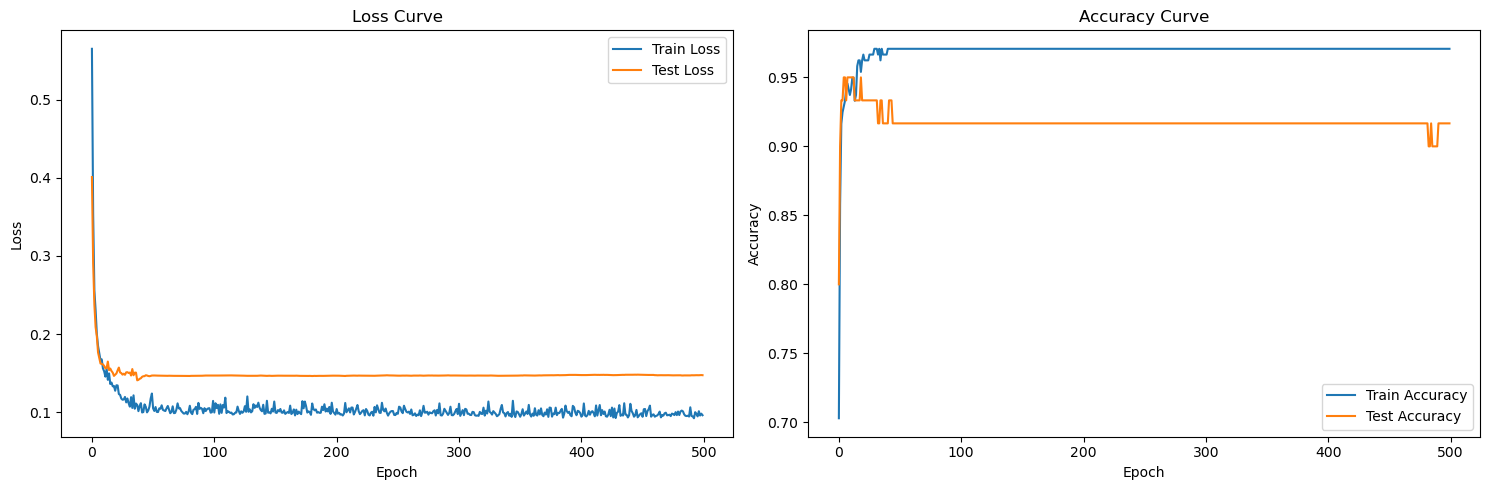

In [19]:
results = train_logreg_simplified(
    batch_size=32,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=500
)




In [20]:
print(f"Best Train Accuracy: {results['best_train_acc']:.4f} at Epoch {results['best_train_epoch']}")
print(f"Best Test Accuracy: {results['best_test_acc']:.4f} at Epoch {results['best_test_epoch']}")

Best Train Accuracy: 0.9707 at Epoch 30
Best Test Accuracy: 0.9500 at Epoch 5


In [19]:
results

{'train_acc': 0.9665271966527197, 'test_acc': 0.9}

In [19]:
logreg_model= best_loss_model
logreg_model


LogisticRegression(
  (linear): Linear(in_features=512, out_features=3, bias=True)
)

# Train the logistic regression model
# Example usage:
best_acc_model, best_loss_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=100
)
#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


# Save the best models by accuracy and loss
torch.save(best_acc_model.state_dict(), "best_acc_model.pth")
torch.save(best_loss_model.state_dict(), "best_loss_model.pth")


# 512= feature_dim = train_feats_simclr.tensors[0].shape[1] =  before projection head

# Save model state_dict
torch.save(logreg_model.state_dict(), "logreg_model_best.pth")


Extracting Features: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


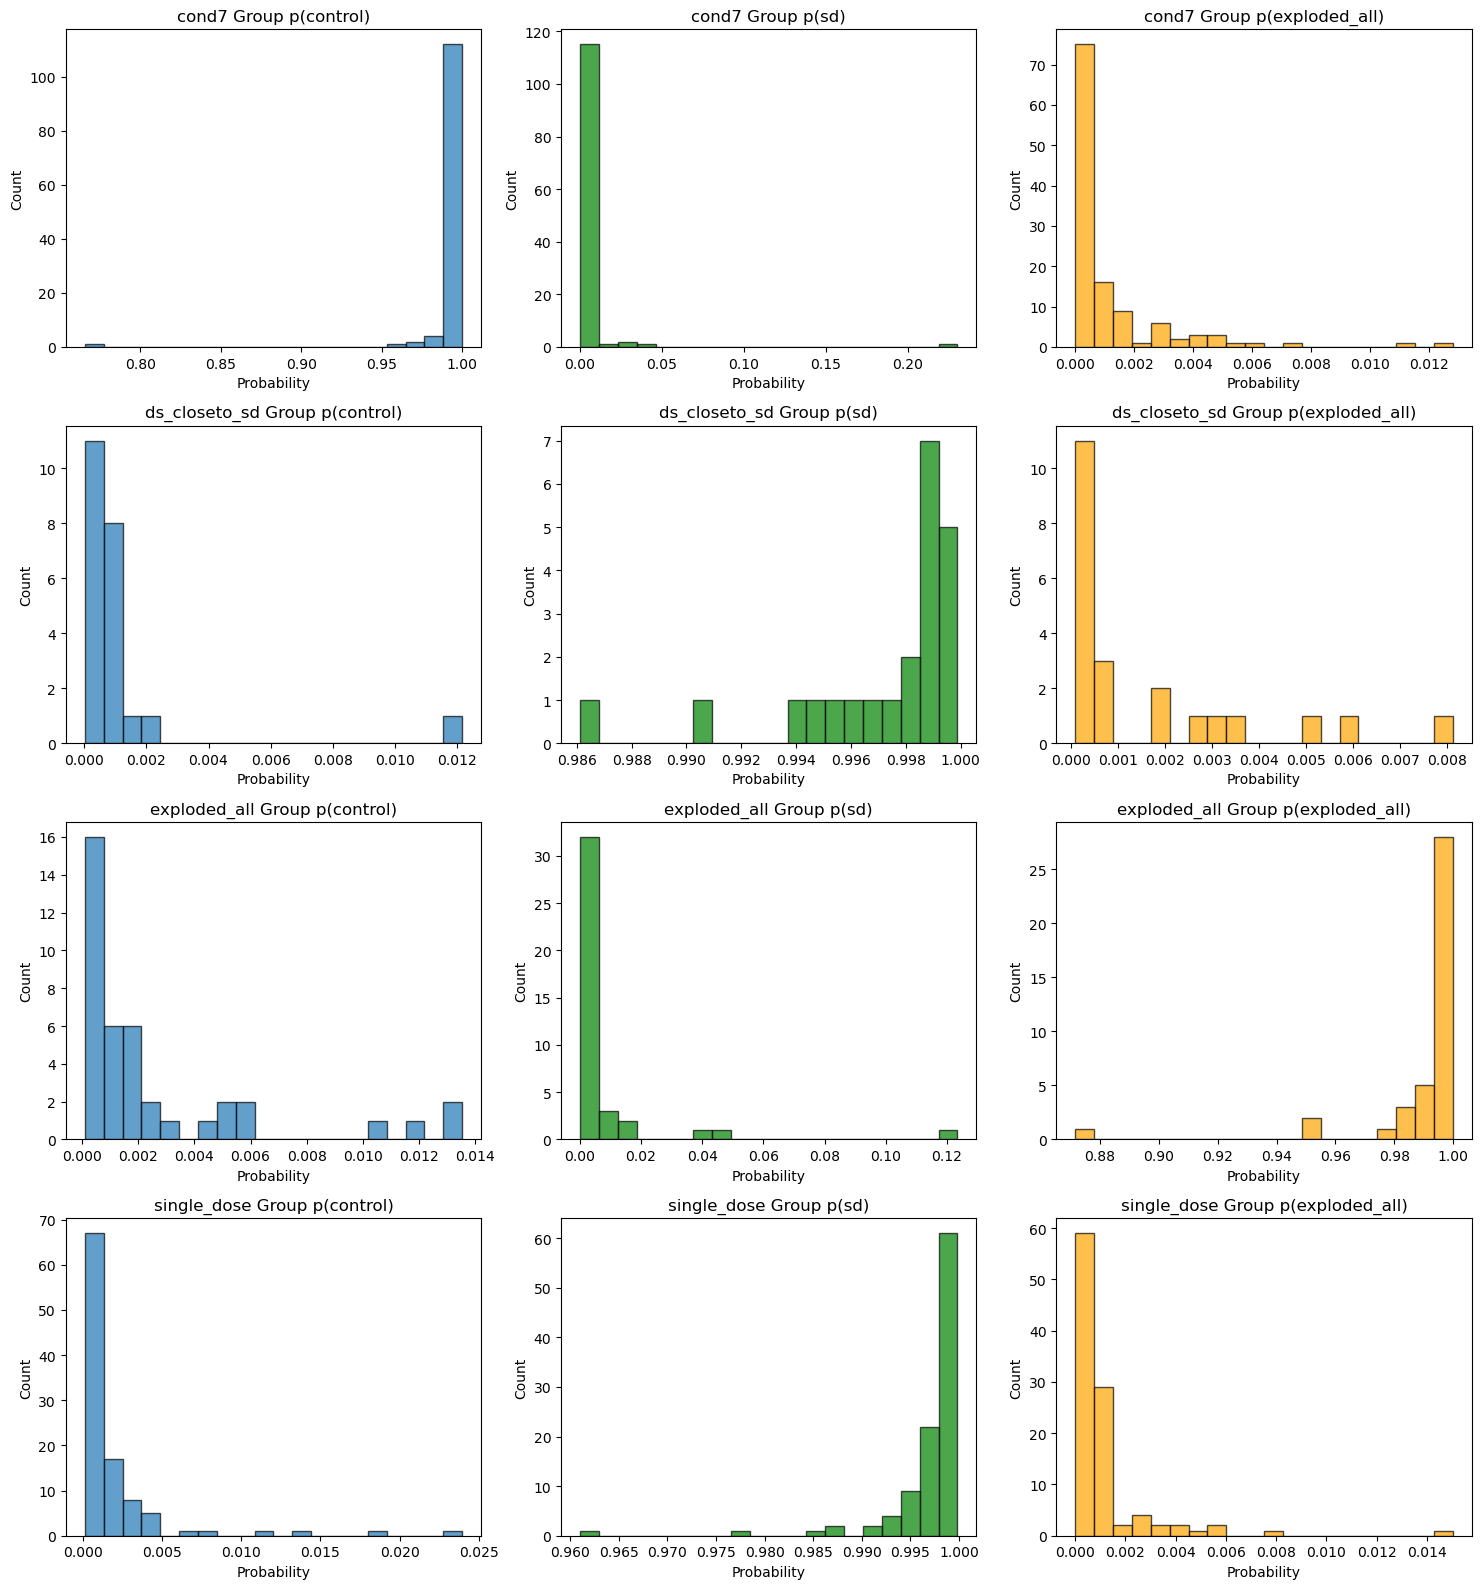

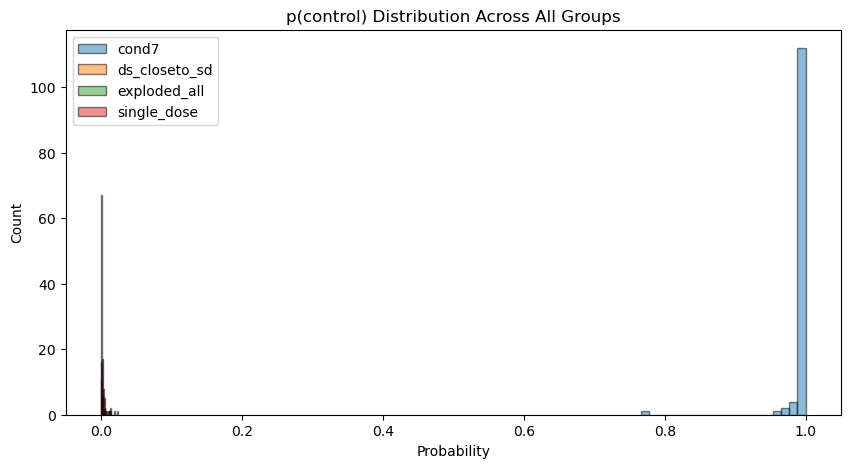

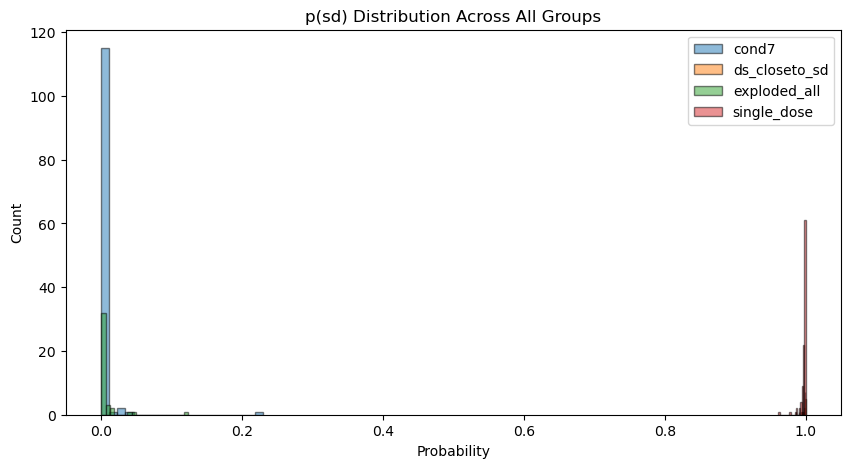

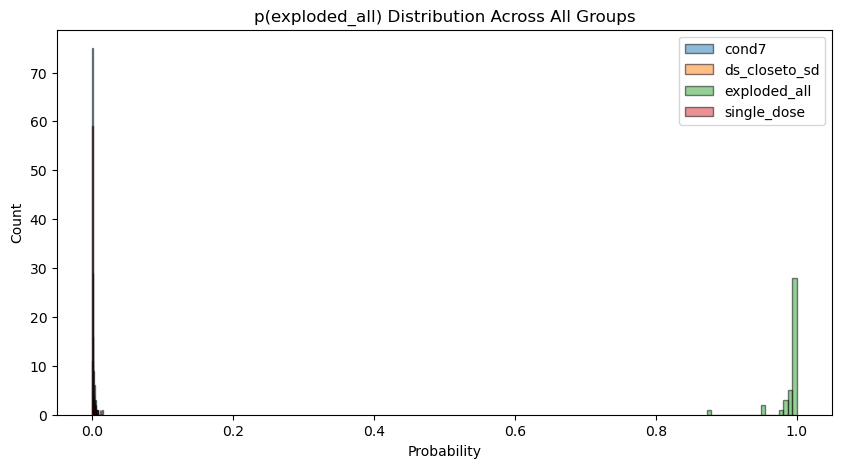

In [20]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for (control, sd, exploded_all) classification.
# device: torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # Dummy labels since it's just inference
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 3]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 3]
# probs[:, 0] = p(control)
# probs[:, 1] = p(sd)
# probs[:, 2] = p(exploded_all)

# Store results by group
# groups_data[group_name] = list of [p_control, p_sd, p_exploded_all, img_path]
groups_data = {g: [] for g in groups}
for p_control, p_sd, p_explod, grp, path in zip(probs[:,0], probs[:,1], probs[:,2], group_names, inference_paths):
    groups_data[grp].append([p_control, p_sd, p_explod, path])

# --------------------
# PLOTTING INDIVIDUAL DISTRIBUTIONS PER GROUP
# Now we have 3 probabilities per image. We will plot 3 histograms per group.
# --------------------

num_groups = len(groups)
# We need 3 subplots per group row now
fig, axs = plt.subplots(num_groups, 3, figsize=(15, 4*num_groups))

if num_groups == 1:
    axs = np.array([axs])  # Ensure axs is 2D even for a single group

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_sd_list = [item[1] for item in groups_data[grp]]
    p_explod_list = [item[2] for item in groups_data[grp]]

    # Plot p(control)
    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    # Plot p(sd)
    axs[i, 1].hist(p_sd_list, bins=20, alpha=0.7, edgecolor='black', color='green')
    axs[i, 1].set_title(f"{grp} Group p(sd)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

    # Plot p(exploded_all)
    axs[i, 2].hist(p_explod_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 2].set_title(f"{grp} Group p(exploded_all)")
    axs[i, 2].set_xlabel("Probability")
    axs[i, 2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# --------------------
# PLOTTING COMBINED DISTRIBUTIONS ACROSS ALL GROUPS
# For each class probability, we combine distributions of all groups
# --------------------

# Combined p(control)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(sd)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_sd_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_sd_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(sd) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(exploded_all)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_explod_list = [item[2] for item in groups_data[grp]]
    plt.hist(p_explod_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(exploded_all) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Done!


In [21]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_sd, p_explod, img_path]
    all_images_data.extend(groups_data[grp])

In [25]:
# Sort by p(control) in ascending order
all_images_data_pcontrol = sorted(all_images_data, key=lambda x: x[0])
sorted_by_control = [(entry[3], entry[0]) for entry in all_images_data_pcontrol]
print("Images sorted by p(control) in ascending order:")
for img_path, p_ctrl in sorted_by_control:
    print(f"{img_path}: {p_ctrl:.4f}")

print("\n" + "-"*50 + "\n")

Images sorted by p(control) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\ds_closeto_sd\ds62_g2_B02-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\ds_closeto_sd\ds42_g5_E06-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\ds_closeto_sd\ds62_g2_B04-T01.tiff: 0.0001
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\exploded_all\ds41_g3_C03-T01.tiff: 0.0001
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\exploded_all\ds41_g3_C05-T01.tiff: 0.0001
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\exploded_all\ds61_g8_B09-T01.tiff: 0.0001
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_C10-T01.tiff: 0.0001
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_F08-T01.tiff: 0.0001
C:\Users\

In [26]:
# Sort by p(sd) in ascending order
all_images_data_psd = sorted(all_images_data, key=lambda x: x[1])
sorted_by_sd = [(entry[3], entry[1]) for entry in all_images_data_psd]
print("Images sorted by p(sd) in ascending order:")
for img_path, p_sd in sorted_by_sd:
    print(f"{img_path}: {p_sd:.4f}")

Images sorted by p(sd) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_E11-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_B03-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D10-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_G05-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D06-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F11-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_C04-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softma

In [27]:
# Sort by p(exploded_all) in ascending order
all_images_data_pexplod = sorted(all_images_data, key=lambda x: x[2])
sorted_by_explod = [(entry[3], entry[2]) for entry in all_images_data_pexplod]
print("Images sorted by p(exploded_all) in ascending order:")
for img_path, p_explod in sorted_by_explod:
    print(f"{img_path}: {p_explod:.4f}")

Images sorted by p(exploded_all) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_E11-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D10-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_C04-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_G05-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_B03-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_G09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_C11-T01.tiff: 0.0000
C:\Users\k54739\Bibi_ne

In [22]:

# 750 epoch result, plot 2 is better.


Extracting Features: 100%|██████████| 18/18 [00:12<00:00,  1.41it/s]


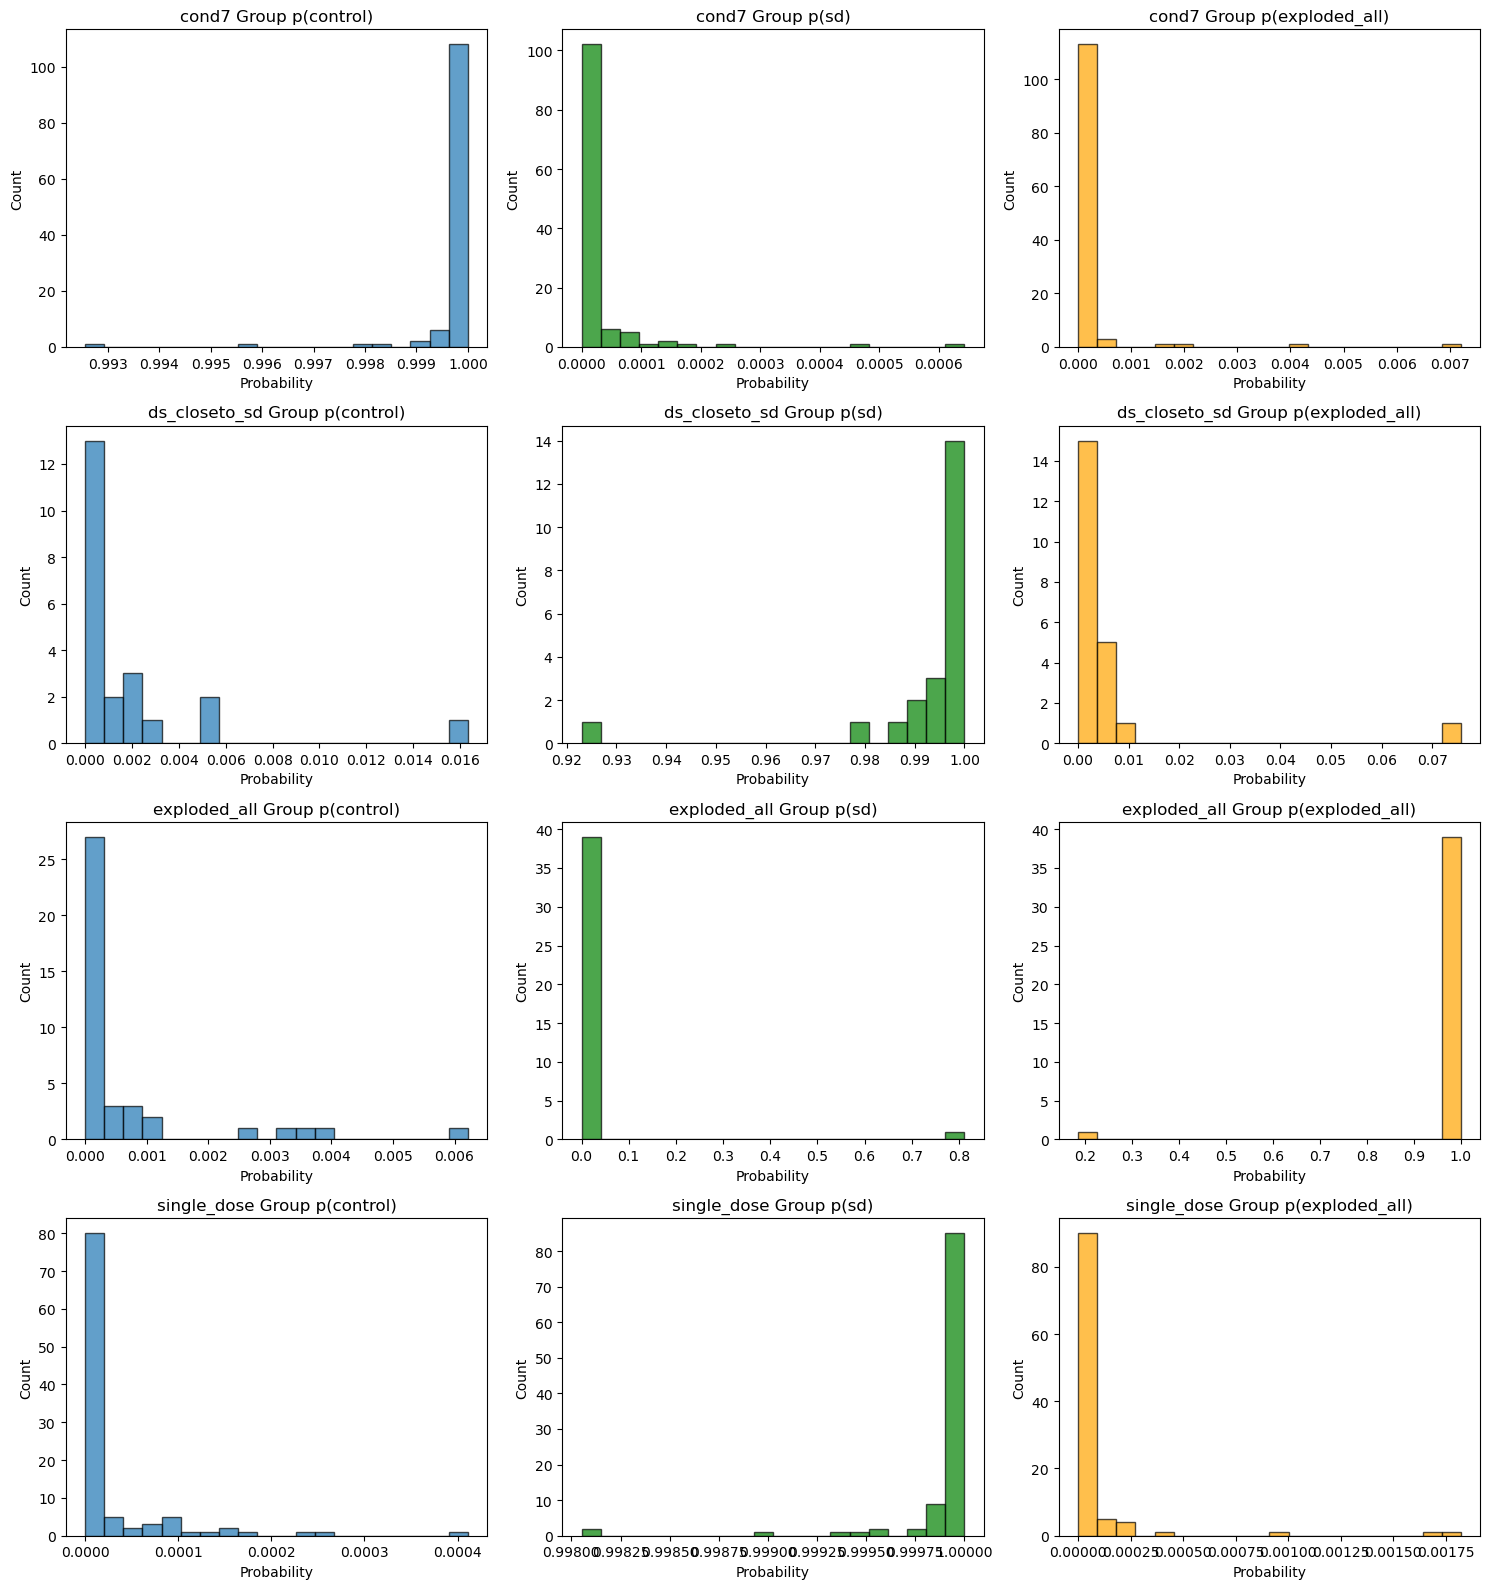

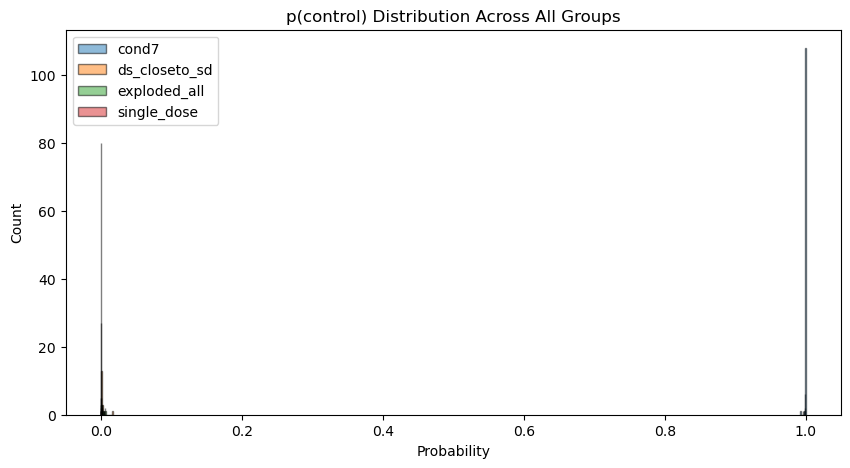

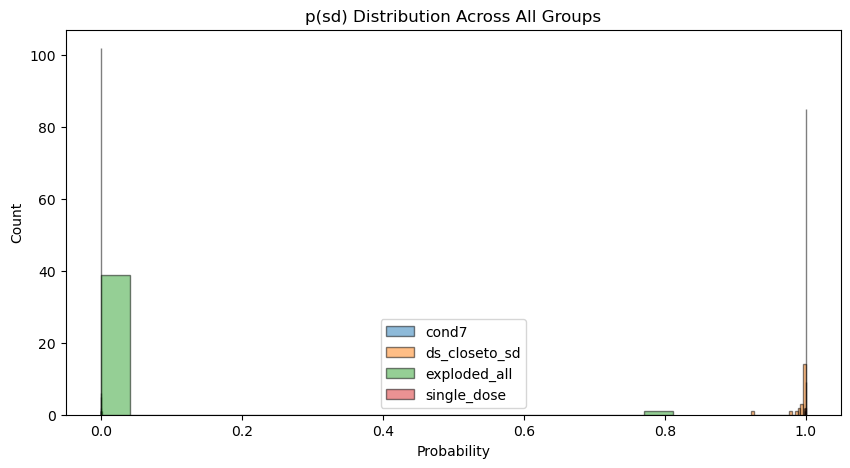

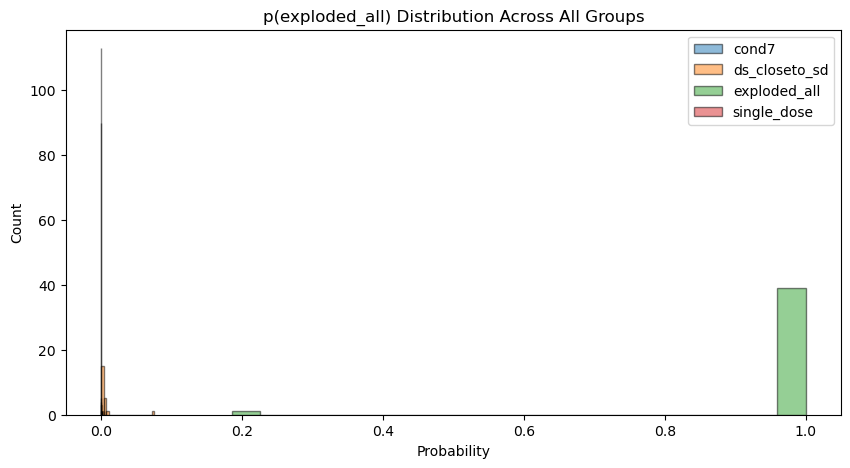

In [23]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import tifffile as tiff
from torchvision import transforms

# Assume simclr_model, logreg_model, device are already defined and loaded.
# simclr_model: the feature extractor model
# logreg_model: the logistic regression model for (control, sd, exploded_all) classification.
# device: torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_all_groups(root_dir):
    # All directories in root_dir are considered different groups
    groups = []
    for d in os.listdir(root_dir):
        dir_path = os.path.join(root_dir, d)
        if os.path.isdir(dir_path):
            groups.append(d)
    return groups

def load_inference_data(root_dir):
    groups = get_all_groups(root_dir)
    
    image_files = []
    group_names = []
    
    # Dummy labels since it's just inference
    dummy_labels = []

    for group in groups:
        class_dir = os.path.join(root_dir, group)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)
                 if file.lower().endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        group_names.extend([group] * len(files))
        dummy_labels.extend([0]*len(files))  # dummy label

    return image_files, dummy_labels, group_names, groups

class LabeledImageDatasetWithPath:
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Handle shape: ensure CxHxW
        if image.ndim == 3 and image.shape[2] == 3:
            image = np.transpose(image, (2, 0, 1))
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} doesn't have 3 channels.")

        image = image.astype(np.float32) / 65535.0
        image = torch.tensor(image, dtype=torch.float32)
        image = self.resize_transform(image)

        label = self.labels[idx]
        return image, label, img_path

@torch.no_grad()
def extract_features(model, dataloader, device):
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()
    network.eval()
    network.to(device)

    all_features = []
    all_labels = []
    all_paths = []
    for batch_imgs, batch_labels, batch_paths in tqdm(dataloader, desc="Extracting Features"):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        all_features.append(batch_feats.cpu())
        all_labels.append(batch_labels)
        all_paths.extend(batch_paths)
    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_features, all_labels, all_paths

@torch.no_grad()
def predict_with_probs(model, features, device):
    model.eval()
    features = features.to(device)
    logits = model(features)  # shape: [N, 3]
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
    return probs.cpu().numpy()

# --------------------
# MAIN INFERENCE FLOW
# --------------------

root_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference"

# 1. Load data from all groups
image_files, dummy_labels, group_names, groups = load_inference_data(root_dir)

# 2. Create dataset and dataloader for inference
inference_dataset = LabeledImageDatasetWithPath(image_files, dummy_labels)
inference_loader = DataLoader(inference_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=0)

# 3. Extract features
inference_feats, inference_true_labels, inference_paths = extract_features(simclr_model, inference_loader, device)

# 4. Get probabilities from logistic regression model
probs = predict_with_probs(logreg_model, inference_feats, device)  # shape [N, 3]
# probs[:, 0] = p(control)
# probs[:, 1] = p(sd)
# probs[:, 2] = p(exploded_all)

# Store results by group
# groups_data[group_name] = list of [p_control, p_sd, p_exploded_all, img_path]
groups_data = {g: [] for g in groups}
for p_control, p_sd, p_explod, grp, path in zip(probs[:,0], probs[:,1], probs[:,2], group_names, inference_paths):
    groups_data[grp].append([p_control, p_sd, p_explod, path])

# --------------------
# PLOTTING INDIVIDUAL DISTRIBUTIONS PER GROUP
# Now we have 3 probabilities per image. We will plot 3 histograms per group.
# --------------------

num_groups = len(groups)
# We need 3 subplots per group row now
fig, axs = plt.subplots(num_groups, 3, figsize=(15, 4*num_groups))

if num_groups == 1:
    axs = np.array([axs])  # Ensure axs is 2D even for a single group

for i, grp in enumerate(groups):
    p_control_list = [item[0] for item in groups_data[grp]]
    p_sd_list = [item[1] for item in groups_data[grp]]
    p_explod_list = [item[2] for item in groups_data[grp]]

    # Plot p(control)
    axs[i, 0].hist(p_control_list, bins=20, alpha=0.7, edgecolor='black')
    axs[i, 0].set_title(f"{grp} Group p(control)")
    axs[i, 0].set_xlabel("Probability")
    axs[i, 0].set_ylabel("Count")

    # Plot p(sd)
    axs[i, 1].hist(p_sd_list, bins=20, alpha=0.7, edgecolor='black', color='green')
    axs[i, 1].set_title(f"{grp} Group p(sd)")
    axs[i, 1].set_xlabel("Probability")
    axs[i, 1].set_ylabel("Count")

    # Plot p(exploded_all)
    axs[i, 2].hist(p_explod_list, bins=20, alpha=0.7, edgecolor='black', color='orange')
    axs[i, 2].set_title(f"{grp} Group p(exploded_all)")
    axs[i, 2].set_xlabel("Probability")
    axs[i, 2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# --------------------
# PLOTTING COMBINED DISTRIBUTIONS ACROSS ALL GROUPS
# For each class probability, we combine distributions of all groups
# --------------------

# Combined p(control)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_control_list = [item[0] for item in groups_data[grp]]
    plt.hist(p_control_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(control) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(sd)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_sd_list = [item[1] for item in groups_data[grp]]
    plt.hist(p_sd_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(sd) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Combined p(exploded_all)
plt.figure(figsize=(10, 5))
for grp in groups:
    p_explod_list = [item[2] for item in groups_data[grp]]
    plt.hist(p_explod_list, bins=20, alpha=0.5, edgecolor='black', label=grp)
plt.title("p(exploded_all) Distribution Across All Groups")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# Done!


In [24]:
all_images_data = []
for grp in groups:
    # each entry is [p_control, p_sd, p_explod, img_path]
    all_images_data.extend(groups_data[grp])

In [25]:
# Sort by p(control) in ascending order
all_images_data_pcontrol = sorted(all_images_data, key=lambda x: x[0])
sorted_by_control = [(entry[3], entry[0]) for entry in all_images_data_pcontrol]
print("Images sorted by p(control) in ascending order:")
for img_path, p_ctrl in sorted_by_control:
    print(f"{img_path}: {p_ctrl:.4f}")

print("\n" + "-"*50 + "\n")

Images sorted by p(control) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_B07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.10_Day10_E09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_B09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_B10-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_B08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_G11-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_G07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\sing

In [26]:
# Sort by p(sd) in ascending order
all_images_data_psd = sorted(all_images_data, key=lambda x: x[1])
sorted_by_sd = [(entry[3], entry[1]) for entry in all_images_data_psd]
print("Images sorted by p(sd) in ascending order:")
for img_path, p_sd in sorted_by_sd:
    print(f"{img_path}: {p_sd:.4f}")

Images sorted by p(sd) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_C05-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D03-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_B07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_G05-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_D03-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\sof

In [27]:
# Sort by p(exploded_all) in ascending order
all_images_data_pexplod = sorted(all_images_data, key=lambda x: x[2])
sorted_by_explod = [(entry[3], entry[2]) for entry in all_images_data_pexplod]
print("Images sorted by p(exploded_all) in ascending order:")
for img_path, p_explod in sorted_by_explod:
    print(f"{img_path}: {p_explod:.4f}")

Images sorted by p(exploded_all) in ascending order:
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.10_Day10_E09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_B09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.09_Day10_B08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_D09-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F07-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBT_01.04_Day7_B08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\cond7\RBTDS1B_Day_7_F08-T01.tiff: 0.0000
C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\inference\single_dose\sd_RBT_01.04_Day10_B10-T01.tif